In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms  # Make sure transforms is imported here as well
from google.colab import files
from collections import OrderedDict


In [26]:
# Initialize the model with the correct pretrained weights for Cityscapes
num_classes = 4 # Update based on your dataset
# Load the model with 'pretrained=True' and specify 'cityscapes' for the weights
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Change the classifier to match the number of classes in your dataset
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Load your model from Google Drive
model_path = '/content/drive/MyDrive/deeplabv3plus_cityscapes.pth'  # Adjust this path if needed

# Load the state dictionary securely
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Load the state dictionary into the model
# Since we initialized with pretrained weights, we don't need to modify the keys
# and can set strict=False to ignore any missing keys
model.load_state_dict(state_dict, strict=False)

model.eval()  # Set the model to evaluation model
# Define the preprocessing: resizing and normalizing
preprocess = transforms.Compose([  # Now transforms should be accessible
    transforms.Resize((512, 512)),  # Resize the image to 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

<ipython-input-26-b9354c7b72f5>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


In [14]:
# Upload and load the image
uploaded = files.upload()  # This will allow you to upload an image
image_path = list(uploaded.keys())[0]  # Get the uploaded image filename


Saving berlin_000002_000019_leftImg8bit.png to berlin_000002_000019_leftImg8bit.png


In [27]:
# Load and preprocess the image
def segment_image(image_path):
    original_image = Image.open(image_path).convert("RGB")  # Load the image
    preprocessed_image = preprocess(original_image).unsqueeze(0)  # Convert to NumPy array
    # Get segmentation output
    with torch.no_grad():
        output = model(preprocessed_image)['out']  # Forward pass
        segmented_image = output.squeeze(0).argmax(0).cpu().numpy()  # Get the class index

    return np.array(original_image), segmented_image


In [34]:
# Visualization function
def visualize_segmentation(original_image, segmented_image):
    # Define a simple colormap for the 4 classes
    colormap = np.array([
        [0, 0, 0],   # Class 0: Background (Black)
        [0, 255, 0], # Class 1: Person (Green)
        [0, 0, 255], # Class 2: Car (Blue)
        [255, 0, 0], # Class 3: Road (Red)
    ])

    # Clip segmented image values to be within the colormap range
    segmented_image_clipped = np.clip(segmented_image.astype(int), 0, colormap.shape[0] - 1)

    # Create a color segmented image
    segmented_color = colormap[segmented_image_clipped] # Use clipped image for indexing

    # Display original and segmented images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_color)
    plt.title("Segmented Image")
    plt.axis('off')

    plt.show()

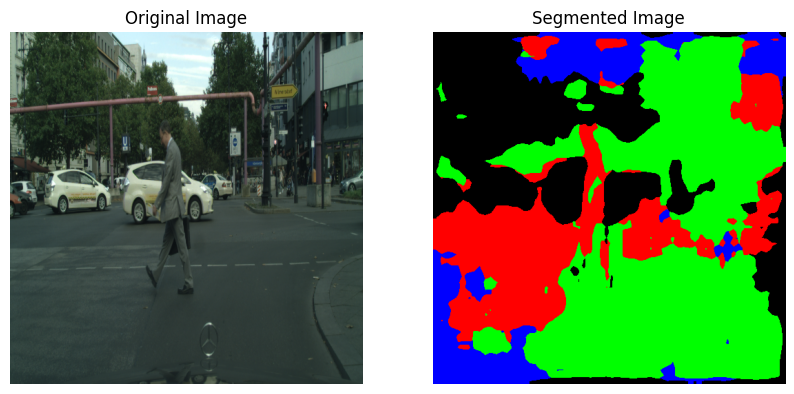

In [35]:
# Run segmentation and visualization
original_image, segmented_image = segment_image(image_path)
visualize_segmentation(original_image, segmented_image)